## Trend Segmentation using Velocity and Acceleration
We will cover:
1. Discussion of trend segments
2. Examine algorithm for segmenting data set using velocity and Acceleration
3. Performing linear regression on trend segments

In [2]:
# Import libraries to manipulate data
import pandas
import numpy 
import matplotlib.pyplot as pyplot

In [3]:
# Import the utilities module we wrote
import importlib.util
spec = importlib.util.spec_from_file_location("utilities", "utilities.py")
utilities = importlib.util.module_from_spec(spec)
spec.loader.exec_module(utilities)

## 1. Discussion of trend segments

In terms of velocity, a trend is a series of data that moves in the same direction; for example, this data is trending up. the nature of the relationship is not of interest. for example we do not care if it is linarelry or exponentially increasing, just that it is increasing. We can identify points in our data set where a trend start/stops by looking for points there the direction changes; in other words, where the slope or velocity changes from positive to negative.

In terms of acceleration, a trend is indicated by what we might consider momentum. There is something pushing a trend which is why it is irratic and temoporary. Accelleration is calculated as the change in velocity; if the acceleration is positive it means that the velocity is increasing meaning the trend is getting stronger. If the acceleration is negative it means that the velocity is decreasing meaning that the trend is reducing.

Together, velocity and acceleration can signal the beginning and strength of a trend. 

In a small time interval, we will consider it a new signal if velocity and acceleration equal zero within the same lagged time window.

## 2. Examine algorithm for segmenting data set using velocity and Acceleration

We will create a dummy data set for the sake of illustrating the algorithm. It contains points which may appear as multiple trends. We will then examine how the different trends are distinguished.

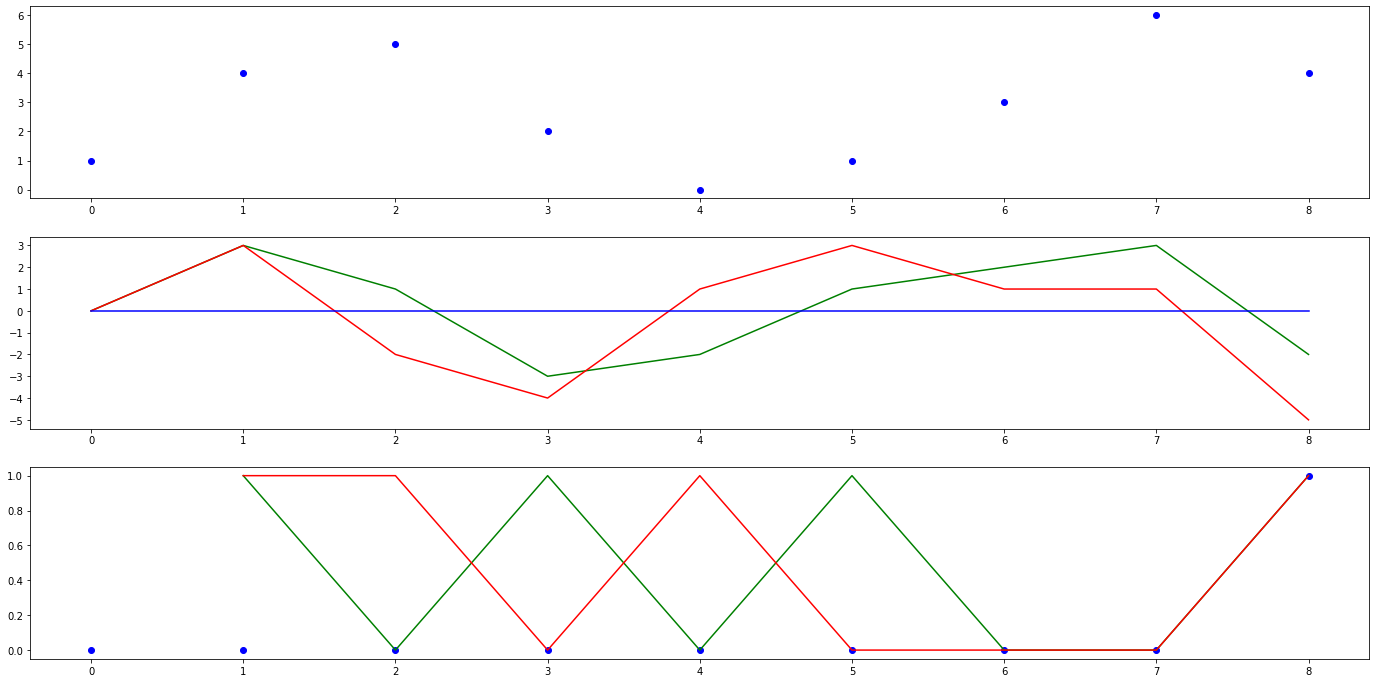

In [4]:
tmp = pandas.DataFrame({
    "x": [0, 1, 2, 3, 4, 5, 6, 7, 8],
    "y": [1, 4, 5, 2, 0, 1, 3, 6, 4]
})
tmp = utilities.calculate_velocity_and_acceleration(tmp, "y")
tmp = utilities.calculate_iflection_point(tmp, "y", debug=True)
figure, axis = pyplot.subplots(nrows=3,ncols=1,figsize=(24,12))
axis[0].scatter(tmp["x"], tmp["y"], color="blue")
axis[1].plot(tmp["x"], tmp["y_v"], color="green")
axis[1].plot(tmp["x"], tmp["y_a"], color="red")
axis[1].plot(tmp["x"], numpy.zeros(tmp["y"].shape[0]), color="blue")

axis[2].scatter(tmp["x"], tmp["y_ip"], color="blue")
axis[2].plot(tmp["x"], tmp["y_v_ip"], color="green")
axis[2].plot(tmp["x"], tmp["y_a_ip"], color="red")


We can see above, in the third chart, that the velocity (green) and acceleration (red) are signaling new trends independently if we look  retrospectively with a one period lag. It's only the last point where the two signal a new trend simultaneously. We can deduce that this is becuase of the relative extema and thus we observe a tolerance for noise within the 

Using this algorithm, the first several points constitute the same segment. 

## Performing linear regression on trend segments

First we ETL our DATA

In [5]:
# Read the file into a dataframe
file_path = "../../nasdaq_2019.csv"
converter_mapping = {
    "date": utilities.convert_date_string_to_date
}
pandas_dataframe = pandas.read_csv(file_path, converters=converter_mapping)

# Sort based on the date column
pandas_dataframe = pandas_dataframe.sort_values("date")

# Filter out data for a specific ticker
aaba_dataframe = pandas_dataframe.loc[pandas_dataframe.ticker == "AABA"]

# Filter down to the last month of data
# aaba_dataframe = aaba_dataframe.loc[aaba_dataframe["date"] > '2019-07-01']

# Remove unwanted columns
aaba_dataframe = aaba_dataframe[["date","open"]]

# Reset the index
aaba_dataframe.index = range(0, aaba_dataframe.shape[0])

# Show the first few rows
aaba_dataframe = aaba_dataframe

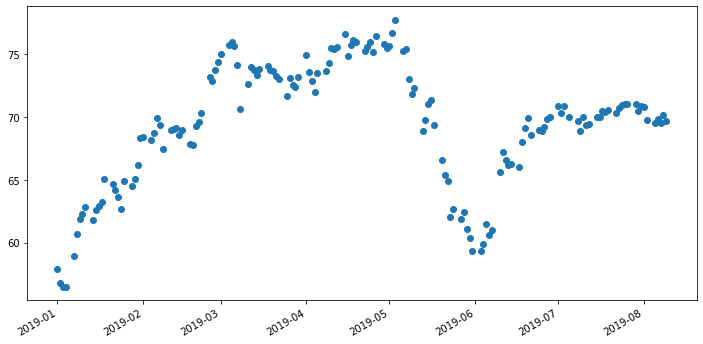

In [6]:
figure, axis = utilities.plot_dataframe(aaba_dataframe, "date", "open")

Next we calculate the Inflection Points

In [7]:
# Determine how many data points are in our series
aaba_dataframe = utilities.calculate_velocity_and_acceleration(aaba_dataframe, "open")
aaba_dataframe = utilities.calculate_iflection_point(aaba_dataframe, "open")
aaba_dataframe.head()

,date,open,open_v,open_a,open_ip
0,2019-01-01,57.94,0.00,0.00,0.0
1,2019-01-02,56.78,-1.16,-1.16,0.0
2,2019-01-03,56.48,-0.30,0.86,0.0
3,2019-01-04,56.50,0.02,0.32,0.0
4,2019-01-07,58.90,2.40,2.38,0.0


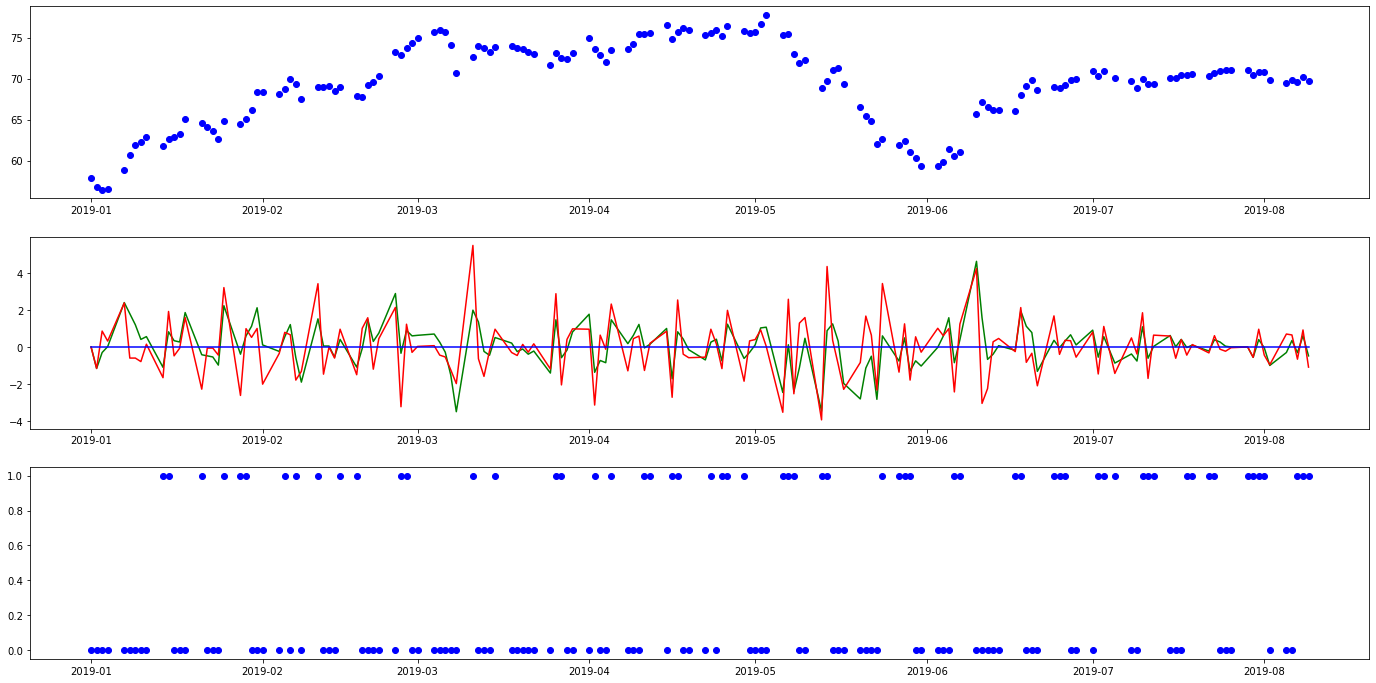

In [8]:
# Plot our three graphs
figure, axis = pyplot.subplots(nrows=3,ncols=1,figsize=(24,12))

axis[0].scatter(aaba_dataframe["date"], aaba_dataframe["open"], color="blue")

axis[1].plot(aaba_dataframe["date"], aaba_dataframe["open_v"], color="green")
axis[1].plot(aaba_dataframe["date"], aaba_dataframe["open_a"], color="red")
axis[1].plot(aaba_dataframe["date"], numpy.zeros(aaba_dataframe["open"].shape[0]), color="blue")

axis[2].scatter(aaba_dataframe["date"], aaba_dataframe["open_ip"], color="blue")

Now that we have figure out how to segment our data, we can apply a model to the segments.

Note: We will need to transform our date column into ordinals becuase the linear regression algorithm only understands numbers, not dates.

In [9]:
# Create a column with the ordinals
aaba_dataframe["ordinals"] = aaba_dataframe["date"].apply(lambda x: x.toordinal())

In [12]:
# Load library for linear regression
from sklearn.linear_model import LinearRegression

# Determine how many data points are in our series
n = aaba_dataframe["open"].shape[0]

# Add some empty columns for the predictions
column_name = "open_pred"
aaba_dataframe[column_name] = numpy.zeros(n)

# Loop through the data points, segment the training data set into segments, and make predictions using linear regression
segment_count = 0
segment_start_index = 0
segment_points = None
for t in range(1, n):
    
    # If we are at an inflection point, update the segment_Start_index
    ip = aaba_dataframe["open_ip"][t - 1]
    if bool(ip):
        segment_start_index = t - 1
    
    # Train the model using the data from the segment
    train_x = aaba_dataframe["ordinals"][segment_start_index:t].values.reshape(-1, 1)
    train_y = aaba_dataframe["open"][segment_start_index:t]
    reg = LinearRegression().fit(train_x, train_y)
    
#    # Calc R-squared
#    r_squared = reg.score(train_x, train_y)
    
    # Reformat our data to a numpy array
    x = aaba_dataframe["ordinals"][t-1:t]
    x = x.values.reshape(-1, 1) # I am not sure why we need to reshape the data
    
    # Make a prediction
    aaba_dataframe.at[t, "open_pred"] = reg.predict(x)  

aaba_dataframe.head()

,date,open,open_v,open_a,open_ip,ordinals,open_pred
0,2019-01-01,57.94,0.00,0.00,0.0,737060,0.000000
1,2019-01-02,56.78,-1.16,-1.16,0.0,737061,57.940000
2,2019-01-03,56.48,-0.30,0.86,0.0,737062,56.780000
3,2019-01-04,56.50,0.02,0.32,0.0,737063,56.336667
4,2019-01-07,58.90,2.40,2.38,0.0,737066,56.232000


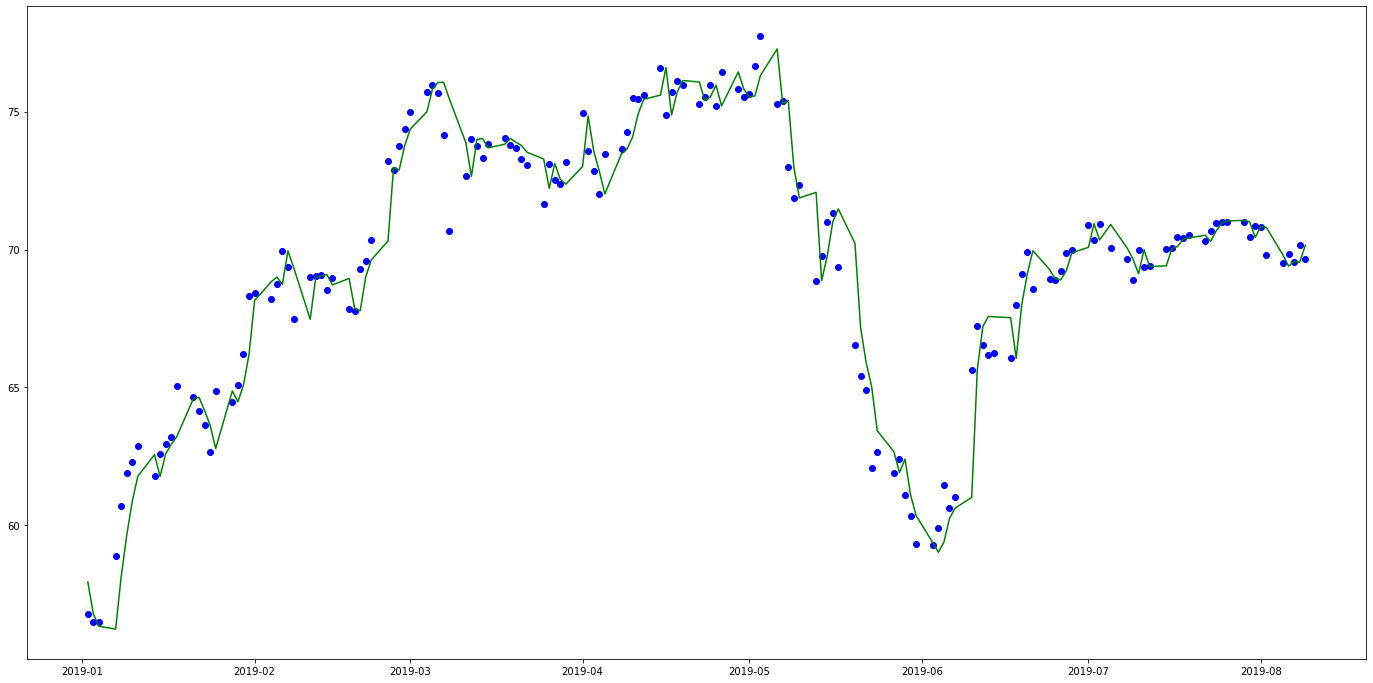

In [16]:
date = aaba_dataframe["date"][1:]
o = aaba_dataframe["open"][1:]
o_hat = aaba_dataframe["open_pred"][1:]

figure, axis = pyplot.subplots(nrows=1,ncols=1,figsize=(24,12))
axis.scatter(date, o, color="blue")
axis.plot(date, o_hat, color="green")

### Look at the error in prediction

In [17]:
aaba_dataframe["pred_error"] = aaba_dataframe["open_pred"] - aaba_dataframe["open"]
aaba_dataframe.head()

,date,open,open_v,open_a,open_ip,ordinals,open_pred,pred_error
0,2019-01-01,57.94,0.00,0.00,0.0,737060,0.000000,-57.940000
1,2019-01-02,56.78,-1.16,-1.16,0.0,737061,57.940000,1.160000
2,2019-01-03,56.48,-0.30,0.86,0.0,737062,56.780000,0.300000
3,2019-01-04,56.50,0.02,0.32,0.0,737063,56.336667,-0.163333
4,2019-01-07,58.90,2.40,2.38,0.0,737066,56.232000,-2.668000


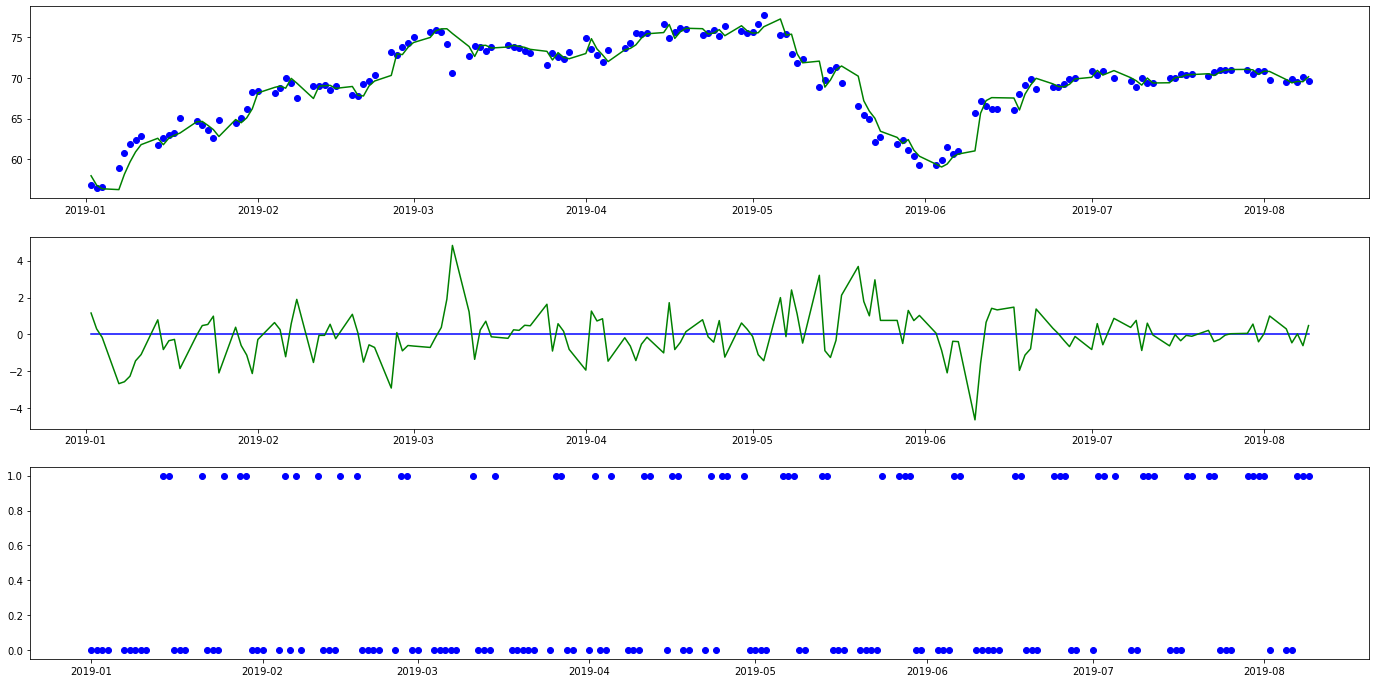

In [18]:
date = aaba_dataframe["date"][1:]
o = aaba_dataframe["open"][1:]
o_hat = aaba_dataframe["open_pred"][1:]
o_error = aaba_dataframe["pred_error"][1:]

figure, axis = pyplot.subplots(nrows=3,ncols=1,figsize=(24,12))
axis[0].scatter(date, o, color="blue")
axis[0].plot(date, o_hat, color="green")
axis[1].plot(date, numpy.zeros(n-1), color="blue")
axis[1].plot(date, o_error, color="green")
axis[2].scatter(aaba_dataframe["date"], aaba_dataframe["open_ip"], color="blue")

### Simulate trading by buying low and selling high
if the estimate is lower than market, sell because the market is overpaying

if the estimate is higher than market, buy because the market is undervaluing 

In [40]:
# Load library for linear regression
from sklearn.linear_model import LinearRegression

# Determine how many data points are in our series
n = aaba_dataframe["open"].shape[0]

# Add some empty columns for the predictions
aaba_dataframe["info"] = ""
aaba_dataframe["signals"] = ""

aaba_dataframe["shares"] = numpy.zeros(n)
aaba_dataframe["cash"] = numpy.zeros(n)
aaba_dataframe["invested"] = numpy.zeros(n)
aaba_dataframe["sale"] = numpy.zeros(n)
aaba_dataframe["returns"] = numpy.zeros(n)
aaba_dataframe["ledger"] = ""
aaba_dataframe["buy"] = numpy.nan
aaba_dataframe["sell"] = numpy.nan



# Set the starting condition
aaba_dataframe.at[0, "cash"] = 500

# Loop through the data points and make predictions using linear regression

ledger = {}

for t in range(1, n):
    
    # Find the index of the previous inflection point
    previous_ip = t
    for x in reversed(range(0, t)):
        ip = aaba_dataframe["open_ip"][x]
        
        previous_ip = x
        if bool(ip):
            break
   
    # Determine if we have enough info (previous ip is at least 1 point away)
    diff = t - previous_ip    
    enough_info = diff >= 2 and not bool(aaba_dataframe["open_ip"][t])
    aaba_dataframe.at[t, "info"]= enough_info
    
    # Update our ledger info as if no action took place
    old_cash = aaba_dataframe["cash"][t - 1]
    old_shares = aaba_dataframe["shares"][t - 1]
    old_invested = 0
    for price in ledger.keys():
        shares = ledger[price]
        invested = price * shares
        old_invested += invested

    aaba_dataframe.at[t, "cash"] = old_cash
    aaba_dataframe.at[t, "shares"] = old_shares
    aaba_dataframe.at[t, "returns"] = 0
    aaba_dataframe.at[t, "ledger"] = str(ledger)
    aaba_dataframe.at[t, "invested"] = old_invested
    
    # If we dont have enough info, do not do anything
    if not enough_info: 
        continue

    # Train the model using the data from the segment
    train_x = aaba_dataframe["ordinals"][previous_ip:t].values.reshape(-1, 1)
    train_y = aaba_dataframe["open"][previous_ip:t]
    reg = LinearRegression().fit(train_x, train_y)

    # Make a prediction and update the ledger
    test = aaba_dataframe["ordinals"][t-1:t].values.reshape(-1, 1)
    o_hat = reg.predict(test)
    aaba_dataframe.at[t, "open_pred"] = o_hat  

    # Detemine trading activity
    # if the estimate is lower than market, sell because the market is overpaying
    # if the estimate is higher than market, buy because the market is undervaluing 
    o = aaba_dataframe["open"][t]
    signal = "none"
    if o_hat < o:
        signal = "sell"
    elif o_hat > o:
        signal = "buy"

    # Execute the trading activity
    if signal == "buy":

        shares_to_buy = int(old_cash / o)
        cost_to_buy = shares_to_buy * o

        # If you cannot buy anything, quit
        if shares_to_buy <= 0:
            continue

        # If you can buy somehting determine the cost
        new_cash = old_cash - cost_to_buy
        
        # Update ledger
        if o not in ledger.keys():
            ledger[o] = shares_to_buy
        else:
            ledger[o] += shares_to_buy
            
        # Determine how much is invested
        total_invested = 0
        for price in ledger.keys():
            shares = ledger[price]
            invested = price * shares
            total_invested += invested

        # update dataframe
        aaba_dataframe.at[t, "cash"] = new_cash
        aaba_dataframe.at[t, "shares"] = old_shares + shares_to_buy
        aaba_dataframe.at[t, "returns"] = 0
        aaba_dataframe.at[t, "ledger"] = str(ledger)
        aaba_dataframe.at[t, "invested"] = total_invested
        aaba_dataframe.at[t, "buy"] = o

    else:
        
        # If we cannot sell, quit
        if old_shares <= 0:
            continue
        
        # If we can sell, determine how much we can make
        # We only want to dump the shares we bought for less than current market price
        buy_prices_to_dump = []
        for buy_price in ledger.keys():
            if buy_price < o:
                buy_prices_to_dump.append(buy_price)
        if(len(buy_prices_to_dump) == 0):
            continue
        
        # Determine number of shares being sold
        shares_to_dump = 0
        for buy_price in buy_prices_to_dump:
            shares = ledger[buy_price]
            shares_to_dump += shares
            
        # Determine the investment of the sale
        investment_of_sale = 0
        for buy_price in buy_prices_to_dump:
            shares = ledger[buy_price]
            investment = shares * buy_price 
            investment_of_sale += investment
               
        # Update ledger
        for buy_price in buy_prices_to_dump:
            del ledger[buy_price]
        
        # Determine how much is invested
        total_invested = 0
        for price in ledger.keys():
            shares = ledger[price]
            invested = price * shares
            total_invested += invested
        
        # Update datafream
        new_shares = old_shares - shares_to_dump
        cash_from_sell = shares_to_dump * o
        
        aaba_dataframe.at[t, "cash"] = old_cash + cash_from_sell
        aaba_dataframe.at[t, "shares"] = new_shares
        aaba_dataframe.at[t, "returns"] = cash_from_sell - investment_of_sale
        aaba_dataframe.at[t, "ledger"] = str(ledger)
        
        aaba_dataframe.at[t, "sale"] = cash_from_sell
        aaba_dataframe.at[t, "invested"] = total_invested
        
        aaba_dataframe.at[t, "sell"] = o
    
    # Update our signal so we know we took an action
    aaba_dataframe.at[t, "signals"] = signal

In [37]:
# Configure pandas to show all the rows
pandas.set_option('display.max_columns', None)  # or 1000
pandas.set_option('display.max_rows', None)  # or 1000
pandas.set_option('display.max_colwidth', -1)  # or 199
aaba_dataframe

<ipython-input-37-b4c6240e412d>:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pandas.set_option('display.max_colwidth', -1)  # or 199


,date,open,open_v,open_a,open_ip,ordinals,open_pred,pred_error,info,signals,shares,cash,invested,sale,returns,ledger,sell,buy
0,2019-01-01,57.94,0.00,0.000000e+00,0.0,737060,0.000000,-57.940000,,,0.0,500.00,0.00,0.00,0.00,,NaN,NaN
1,2019-01-02,56.78,-1.16,-1.160000e+00,0.0,737061,57.940000,1.160000,False,,0.0,500.00,0.00,0.00,0.00,{},NaN,NaN
2,2019-01-03,56.48,-0.30,8.600000e-01,0.0,737062,56.780000,0.300000,True,buy,8.0,48.16,451.84,0.00,0.00,{56.48: 8},56.48,NaN
3,2019-01-04,56.50,0.02,3.200000e-01,0.0,737063,56.336667,-0.163333,True,sell,0.0,500.16,0.00,452.00,0.16,{},NaN,56.50
4,2019-01-07,58.90,2.40,2.380000e+00,0.0,737066,56.232000,-2.668000,True,,0.0,500.16,0.00,0.00,0.00,{},NaN,NaN
5,2019-01-08,60.70,1.80,-6.000000e-01,0.0,737067,58.135094,-2.564906,True,,0.0,500.16,0.00,0.00,0.00,{},NaN,NaN
6,2019-01-09,61.90,1.20,-6.000000e-01,0.0,737068,59.636137,-2.263863,True,,0.0,500.16,0.00,0.00,0.00,{},NaN,NaN
7,2019-01-10,62.31,0.41,-7.900000e-01,0.0,737069,60.878301,-1.431699,True,,0.0,500.16,0.00,0.00,0.00,{},NaN,NaN
8,2019-01-11,62.87,0.56,1.500000e-01,0.0,737070,61.777866,-1.092134,True,,0.0,500.16,0.00,0.00,0.00,{},NaN,NaN
9,2019-01-14,61.77,-1.10,-1.660000e+00,1.0,737073,62.561265,0.791265,False,,0.0,500.16,0.00,0.00,0.00,{},NaN,NaN


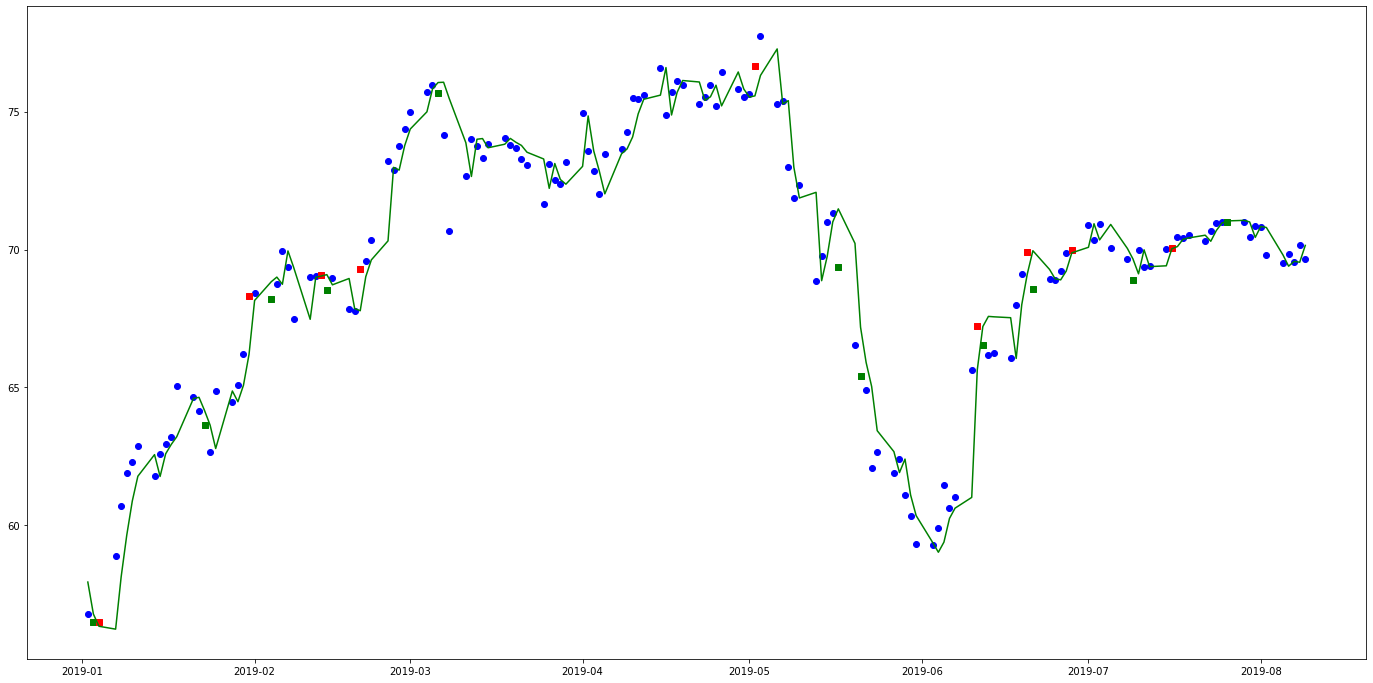

In [54]:
date = aaba_dataframe["date"][1:]
o = aaba_dataframe["open"][1:]
o_hat = aaba_dataframe["open_pred"][1:]
buy = aaba_dataframe["buy"][1:]
sell = aaba_dataframe["sell"][1:]

figure, axis = pyplot.subplots(nrows=1,ncols=1,figsize=(24,12))

axis.scatter(date, o, color="blue")
axis.plot(date, o_hat, color="green")
axis.scatter(date, buy, color="green", marker="s")
axis.scatter(date, sell, color="red", marker="s")

Lets look at how this simple algorithm behaved

In [42]:
aaba_dataframe["returns"].sum()

80.89000000000021

In [43]:
aaba_dataframe["returns"].sum() / 500

0.16178000000000042

In [46]:
aaba_dataframe["pred_error"].mean()

-0.3923545687842805

So we have taken a simple and inaccurate model and managed to turn a significant return!